In [28]:
import pandas
import numpy
import matplotlib.pyplot as plt
from xlwt import Workbook
import math
import timeit
from timeit import default_timer as timer
start=timeit.timeit()
df = pandas.read_excel('Data.xlsx', sheet_name='Sheet1', usecols=['Time', 'T Inside', 'I_L1 [A]', 'I_L2 [A]', 'I_L3 [A]'])
load='I_L1 [A]'
z=numpy.size(df[load])

In [29]:
j=0
class Trans():
    def __init__(self, therm_class, a, b, hot_spot,avg_wnd):
        self.therm_class=therm_class
        self.a=a
        self.b=b
        self.hot_spot=hot_spot
        self.avg_wnd=avg_wnd
    def show(self):
        print("Thermal class:", self.therm_class)
        print("Arrhenius' constant a:", self.a)
        print("Arrhenius' constant b:", self.b)
        print("Rated hotspot winding temperature:", self.hot_spot)
        print("Average winding temperature rise:", self.avg_wnd)

In [30]:
A=Trans(105, 3.10e-14, 15900, 130, 50)
E=Trans(120, 5.48e-15, 17212, 145, 70)
B=Trans(130, 1.72e-15, 18115, 155, 75)
F=Trans(155, 9.60e-17, 20475, 180, 80)
H=Trans(180, 5.350e-18, 22979, 205, 100)
I_200=Trans(200, 5.31e-19, 25086, 225, 130)
I_220=Trans(220, 6.26e-20, 27255, 245, 150)
x=str(input("Enter insulation class (A,B,E,F,H,200 or 220):"))
if (x=='A' or x=='a'):
    x=A
    name='A'
elif (x=='B' or x=='b'):
    x=B
    name='B'
elif (x=='E' or x=='e'):
    x=E
    name='E'
elif (x=='F' or x=='f'):
    x=F
    name='F'
elif (x=='200'):	
    x=I_200
    name='200'
elif (x=='H' or x=='h'):
    x=H
    name='H'
elif (x=='220'):
    x=I_220
    name='220'
else:
    x=0
    print("Wrong insulation class entered!")

Enter insulation class (A,B,E,F,H,200 or 220):f


In [31]:
def lifetime(x, t, temp, amb_t):
    return 180000*t*pow(x.a, -1)*math.exp(-x.b/(temp+273+amb_t))

Q=input("Enter operation type (type 'AN' for 'air-natural' or 'AF' for 'air-forced'):")
if(Q=='AN' or Q=='an'):
    q=1.6
else:
    q=2.0
tau_r=0.5#rated time constant
z=1.25#constant

def delta_theta_u(theta_i, theta_u, tau, t): #hot-spot temperature rise 
    return theta_i+(theta_u-theta_i)*(1-math.exp(-t/tau))
def ageing_rate(x, temp, amb_t):
    return 180000*pow(x.a, -1)*math.exp(-x.b/(temp+273+amb_t))

Enter operation type (type 'AN' for 'air-natural' or 'AF' for 'air-forced'):an


In [32]:
#Calculate per unit loading
def pu_loading(S,V):
    return S*1000/(3*V)
S=float(input("Enter transformer ratings\nS (kVA):"))
V=int(input("V (V):"))
I_l=float(pu_loading(S, V))
print("Iline="+str(I_l)+"A")

Enter transformer ratings
S (kVA):1000
V (V):420
Iline=793.6507936507936A


In [33]:
d_time=int(input("Specify time interval between samples (in min):"))
y=numpy.size(df[load])
i=0
I_u=[]
theta_i=[]
theta_u=[]
tau=[]
hot_spot_temp=[]
age_rate=[]
k=[]
amb_t=[]
I_l1=[]
d_time=d_time/60
while y!=i:
    amb_t.append(df.iloc[i]['T Inside'])
    I_l1.append(df.iloc[i][load]/I_l)
    if i==0:
        theta_i.append(0)
        theta_u.append(z*x.avg_wnd*pow(I_l1[i], q))
        tau.append('')
        hot_spot_temp.append(theta_u[i])
        age_rate.append(ageing_rate(x, hot_spot_temp[i], amb_t[i]))
        I_u.append(I_l1[i])
        k.append(1)
        i=i+1
    else:
        I_i=I_l1[i-1]
        I_u=I_l1[i]
        if I_u==I_i:
            theta_u.append(theta_u[i-1])
            j=1
            while I_u==I_l1[i-j]:
                j=j+1
            I_i=I_l1[i-j]
            theta_i.append(z*x.avg_wnd*pow(float(I_i), q))
            tau.append(tau_r*((theta_u[i]/theta_r)-(theta_i[i]/theta_r))/(pow(theta_u[i]/theta_r, z)-pow(theta_i[i]/theta_r, z)))
            hot_spot_temp.append(delta_theta_u(theta_i[i], theta_u[i], tau[i], j*d_time))
            age_rate.append(ageing_rate(x, hot_spot_temp[i], amb_t[i]))
            if(i==y-1):
                k.append(1)
            elif(i%2==0):
                k.append(2)
            else:
                k.append(4)
            i=i+1
            continue
        else:

            theta_i.append(z*x.avg_wnd*pow(float(I_i), q))
            theta_u.append(z*x.avg_wnd*pow(float(I_u), q))
            theta_r=z*x.avg_wnd
            tau.append(tau_r*((theta_u[i]/theta_r)-(theta_i[i]/theta_r))/(pow(theta_u[i]/theta_r, z)-pow(theta_i[i]/theta_r, z)))


            t_i=df.iloc[i-1]['Time']
            t_f=df.iloc[i]['Time']
            #d_time=abs(t_f.hour+t_f.minute/60+t_f.second/3600-(t_i.hour+t_i.minute/60+t_i.second/3600))
            
            hot_spot_temp.append(delta_theta_u(theta_i[i], theta_u[i], tau[i], d_time))
            age_rate.append(ageing_rate(x, hot_spot_temp[i], amb_t[i]))
            if(i==y-1):
                k.append(1)
            elif(i%2==0):
                k.append(2)
            else:
                k.append(4)
            i=i+1


Specify time interval between samples (in min):10


In [34]:
#Interface
wb=Workbook()
sheet1=wb.add_sheet('sheet1')
sheet1.write(0, 0, 'Time') 
sheet1.write(0, 1, 'Loading') 
sheet1.write(0, 2, 'Ultimate Hot-Spot temperature rise') 
sheet1.write(0, 3, 'Time constant') 
sheet1.write(0, 4, 'Hot-spot temperature rise')
sheet1.write(0, 5, 'Ageing rate')
sheet1.write(0, 6, 'Life consumption')
sheet1.write(0, 7, 'K')
sheet1.write(0, 8, 'Kxfactor')
sheet1.write(0, 9, 'Maximum permissible load')
j=1
sum=0
for i in range(0, y):
	#print(i, theta_u[i], tau[i], hot_spot_temp[i], age_rate[i])
	sheet1.write(j,0,i)
	sheet1.write(j,1,I_l1[i])
	sheet1.write(j,2,theta_u[i])
	sheet1.write(j,3,tau[i])
	sheet1.write(j,4,hot_spot_temp[i])
	sheet1.write(j,5,age_rate[i])
	sheet1.write(j,6,d_time*age_rate[i])
	sheet1.write(j,7,k[i])
	sheet1.write(j,8,k[i]*d_time*age_rate[i])
	sheet1.write(j,9,pow((x.hot_spot-amb_t[i])/(z*x.avg_wnd),1/q))
	sum=sum+k[i]*age_rate[i]*d_time
	j=j+1

wb.save('Results.xls')

In [35]:
results=pandas.read_excel('Results.xls', sheet_name='sheet1')
print(results)

      Time   Loading  Ultimate Hot-Spot temperature rise  Time constant  \
0        0  0.538146                           37.105662            NaN   
1        1  0.571284                           40.828488       0.506310   
2        2  0.558936                           39.425693       0.502579   
3        3  0.548856                           38.294241       0.506626   
4        4  0.557550                           39.269386       0.506880   
...    ...       ...                                 ...            ...   
2293  2293  0.659106                           51.324937       0.469505   
2294  2294  0.655326                           50.854787       0.473126   
2295  2295  0.626724                           47.350233       0.477861   
2296  2296  0.616014                           46.062227       0.483859   
2297  2297  0.629622                           47.701038       0.483408   

      Hot-spot temperature rise  Ageing rate  Life consumption  K  Kxfactor  \
0                   

In [36]:
print("Lifetime consumed:"+str(round(sum*2/6, 8))+" hours")
print("Remained life:"+str(180000-round(sum*2/6, 8))+" hours")

Lifetime consumed:158.75641857 hours
Remained life:179841.24358143 hours


In [37]:
#a load and a temperature influence on trasformer's aging rate
graph=pandas.read_excel('Results.xls', sheet_name='sheet1', usecols=['Time', 'Loading', 'Hot-spot temperature rise', 'Ageing rate'])

In [38]:
xyz=graph['Time']*10/60
plt.rcParams["figure.figsize"] = [10, 2]

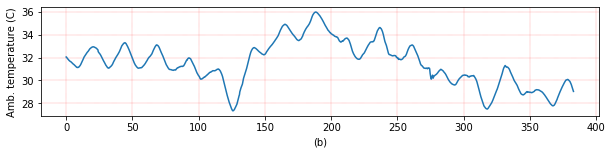

In [39]:
plt.plot(xyz, amb_t)
plt.xlabel('(b)') 
# naming the y axis 
plt.ylabel('Amb. temperature (C)')
#plt.scatter(xyz, graph['Loading'],color="blue")
plt.grid(color='r', linestyle='--', linewidth=0.2)



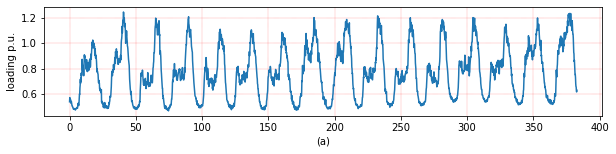

In [40]:
plt.plot(xyz, graph['Loading'])
plt.xlabel('(a)') 
# naming the y axis 
plt.ylabel('loading p.u.')
#plt.scatter(xyz, graph['Loading'],color="blue")
plt.grid(color='r', linestyle='--', linewidth=0.2)

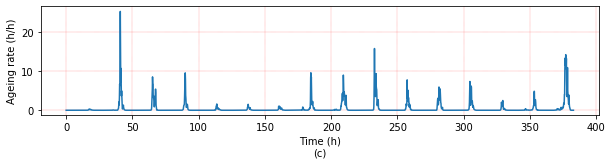

In [41]:
plt.plot(xyz, graph['Ageing rate'])
plt.xlabel('Time (h)\n(c)') 
# naming the y axis 
plt.ylabel('Ageing rate (h/h)')
#plt.scatter(xyz, graph['Loading'],color="blue")
plt.grid(color='r', linestyle='--', linewidth=0.2)

In [42]:
pwd

'C:\\Users\\456'